In [1]:
from fastai.vision.all import *
import fastai

In [2]:
path = untar_data(URLs.IMAGENETTE, archive='D:\FastAi_Data')

In [3]:
dblock = DataBlock(
    blocks = (ImageBlock,CategoryBlock),
    get_items= get_image_files,
    get_y = parent_label,
    item_tfms= Resize(460),
    batch_tfms= aug_transforms(size=224, min_scale=0.75))
dls = dblock.dataloaders(path,bs=64)

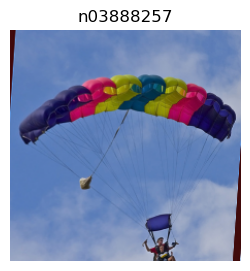

In [4]:
dls.show_batch(max_n=1)

In [5]:
model = xresnet18(n_out = dls.c)
learn = Learner(dls, model, loss_func = CrossEntropyLossFlat(), metrics = accuracy)
learn.fit_one_cycle(5,3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.553174,1.881664,0.396938,03:17
1,1.151271,1.193025,0.623600,03:00
2,0.900005,0.800359,0.740851,03:00
3,0.700473,0.612058,0.804332,02:59
4,0.584190,0.541055,0.832338,02:59


In [6]:
preds,targs = learn.tta()
accuracy(preds, targs).item()

0.8379387855529785

In [7]:
class CornerAndCenterCrop(Transform):
    def __init__(self, size, corner = 0, **kwargs):
        self.size = size
        self.corner = corner
    
    def encodes(self, x:(Image.Image,TensorBBox,TensorPoint)):
        self.w, self.h = x.size
        
        left = self.w- self.size
        top = self.h- self.size
        right = self.w
        bottom = self.h
        
        self.crops = [
            x.crop((0, 0, self.size, self.size)), ## top-left
            x.crop((left, 0, right, self.size)), ## top-right
            x.crop((0, top, self.size,bottom)), ## bottom-left
            x.crop((left, top, right,bottom)), ## bottom-right
            x.crop(((self.w/2)-self.size/2, self.h/2 - self.size/2,   ## Center
                      (self.w/2)+self.size/2, self.h/2 + self.size/2 )),
        ]
        
        return self.crops[self.corner]

In [9]:
dblock_test = DataBlock(
    blocks = (ImageBlock,CategoryBlock),
    get_items = get_image_files,
    get_y = parent_label,
    item_tfms= CornerAndCenterCrop(164,0)
)

dls_test = dblock_test.dataloaders(path,bs=64)

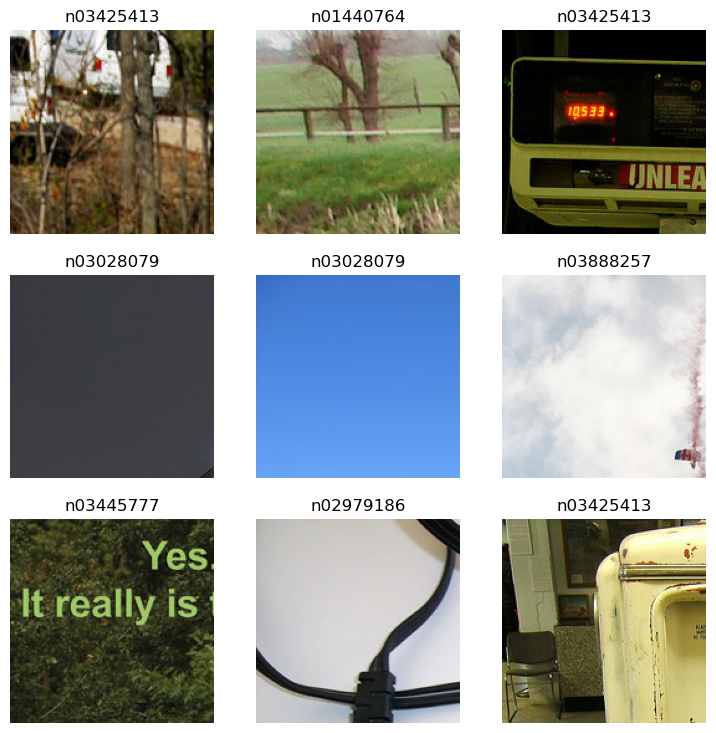

In [10]:
dls_test.show_batch()

In [11]:
class Learner2(Learner): ## Created a new Learner to be used by our model
    def corner_center_tta(self:Learner, ds_idx=1, dl=None, n=5, item_tfms=None, batch_tfms=None, beta=0.25, use_max=False):
        ## modified the tta function from the fastai docs
        "Return predictions on the `ds_idx` dataset or `dl` using Test Time Augmentation"
        if dl is None: dl = self.dls[ds_idx].new(shuffled=False, drop_last=False)
        # if item_tfms is not None or batch_tfms is not None: dl = dl.new(after_item=item_tfms, after_batch=batch_tfms)
        try:
            # self(_before_epoch)
            with dl.dataset.set_split_idx(0), self.no_mbar():
                if hasattr(self,'progress'): self.progress.mbar = master_bar(list(range(n)))
                aug_preds = []
                for i in self.progress.mbar if hasattr(self,'progress') else range(n):
                    dl = dl.new(after_item=[CornerAndCenterCrop(164,i), ToTensor])
                    self.epoch = i #To keep track of progress on mbar since the progress callback will use self.epoch
                    aug_preds.append(self.get_preds(dl=dl, inner=True)[0][None])
            aug_preds = torch.cat(aug_preds)
            aug_preds = aug_preds.max(0)[0] if use_max else aug_preds.mean(0)
            self.epoch = n
            with dl.dataset.set_split_idx(1): preds,targs = self.get_preds(dl=dl, inner=True)
        finally: self(event.after_fit)

        if use_max: return torch.stack([preds, aug_preds], 0).max(0)[0],targs
        preds = (aug_preds,preds) if beta is None else torch.lerp(aug_preds, preds, beta)
        return preds,targs

In [12]:
model = xse_resnet18(n_out = dls.c)
learn = Learner2(dls, model, loss_func = CrossEntropyLossFlat(), metrics = accuracy)
learn.fit_one_cycle(5,3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.547200,2.765377,0.327483,04:10
1,1.148478,1.240049,0.625840,04:12
2,0.913090,0.950807,0.705751,04:12
3,0.694451,0.621437,0.802091,04:11
4,0.563956,0.529652,0.833831,04:11


In [13]:
preds,targs = learn.tta()
accuracy(preds, targs).item()

0.8375653624534607

In [14]:
preds,targs = learn.corner_center_tta()
accuracy(preds, targs).item()

0.5903659462928772

### Comparision between fastai tta and centre crop tta

tta_fastai accuracy = 0.84
my tta accuracy = 0.60
